# PeopleModels

## By Todd Dole, for CSCA-5642 Deep Learning

## Project Description

In this project, I will seek to optimize a machine learning model to accurately count the number of people present in still images.  This is ne portion of a larger project I am currently engaged in, to create an automated attendance recording system for class lectures for the university where I work.  The setting I am ultimately interested in is highly optimal, with students well spaced out amongst desks, the room well lit, and little overlap between persons and other objects.  However, the scope of this project will be more general, focusing on a much broader range of scenarios and situations where people might be found on camera.  If I can achieve a highly accurate model in a broad range of images, including many less than optimal settings, then the ultimate goal of counting students in a classroom will be easily achieved.

We will compare a number of versions of two major types of models: a set of classification based models utilizing Yolov8, a cutting edge object detection model based on CNN architecture (with some additions) and a set of regression based models utilitiing VGG16, a somewhat older but highly successful model.

These models have been built, optimized and tested on a high end machine learning workstation.  This notebook will include samples of training and testing code, a presentation of the metrics and discussion of the outcome.

## References

#### YOLOv8 (Ultralytics)
1. Ultralytics YOLOv8 Documentation: Comprehensive details on YOLOv8's implementation and features. [Visit Documentation](https://docs.ultralytics.com/).
2. Ultralytics GitHub Repository: Source code and community discussions for YOLOv8. [Visit GitHub](https://github.com/ultralytics/ultralytics).

#### VGG16
1. Karen Simonyan & Andrew Zisserman (2014). "Very Deep Convolutional Networks for Large-Scale Image Recognition." [Read the Paper](https://arxiv.org/abs/1409.1556).
2. François Chollet. "Deep Learning with Python." Provides practical applications and explanations of CNNs including VGG16. [Learn More](https://www.manning.com/books/deep-learning-with-python).

### Licensing and Attribution

This project uses the YOLOv8 model, developed by Ultralytics. The model and associated tools are open-source under the GNU General Public License v3.0. For more details, visit the [Ultralytics YOLOv8 GitHub repository](https://github.com/ultralytics/yolov8).

We adhere to the terms of this license by using this model for academic purposes, and we acknowledge Ultralytics' development of the YOLOv8 model.

### Let's begin with some imports below:

In [1]:
!pip install ipywidgets
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import json
import pickle
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import datetime
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from PIL import Image
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, precision_score, recall_score, confusion_matrix
from ipywidgets import IntProgress
from IPython.display import display
import time
import fnmatch
print("Imports finished.")

Imports finished.


# EDA

## COCO - Common Objects in Context (www.cocodataset.org)

My project utilizes data from COCO.  The coco datasets include a vast number of images that have been processed and annotated to identify and mark common objects present in the images. In total, the dataset contains 80 classes of objects which are tracked and annotated in the image set.  (A complete list is available at the COCO Dataset website.  Because this project is focused on detecting persons, which is one of the 80 classes of object, the others are not directly relevant to us.)

My data set consists of the COCO 2017 image set, including 118,000 Train images, 41,000 Test and 5,000 Val Images.  In addition to the images, the dataset also includes annotations for each of the Train and Val folders.  The annotations mark which sections of the image contain which objects.  For instance, in the image below, the annotations mark a person, a bicycle, a backpack, and two horses:



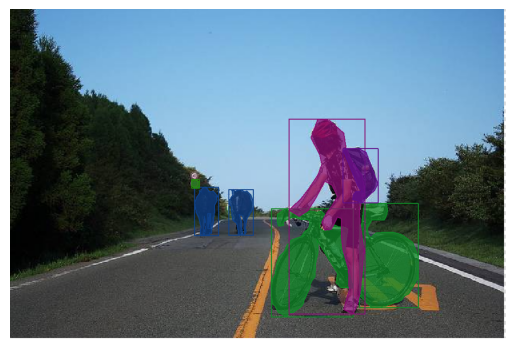

In [2]:
# Load the image
image = Image.open("img/image1.png")

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

## Data Cleaning and Transformation

The COCO Dataset has been extensively curated and contains no nan values or invalid images.  No Data Cleaning was necessary.

Because the COCO 2017 dataset is organized differently than the format YOLOv8 uses for data input, I restructured the data using a custom script I wrote called coco_to_yolo.py (source available in my github repository.)

This placed the files in three subdirectories of data/coco_dataset: train/, val/ and test2017/ .  /train and val/ each have subdirectories images/ and labels/ .  labels/ contains a .txt file for each image in the /images directory with bounding box information for the objects.  (This format was also acceptable to the VGG16 model.)

# Image Counts

In [3]:
# Code to show how many images are in train/
import os
from PIL import Image

# Directories
train_dir = "data/coco_dataset/train/images"
val_dir = "data/coco_dataset/val/images"

def analyze_images(image_dir):
    image_count = 0
    widths = []
    heights = []

    filelist = os.listdir(image_dir)
    max_count = len(fnmatch.filter(filelist, '*.*')) / 1000

    for filename in filelist:
        # Check for image file extensions
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            
            image_count += 1
                
            try:
                # Open image to get dimensions
                with Image.open(os.path.join(image_dir, filename)) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    if widths and heights:
        width_range = (min(widths), max(widths))
        height_range = (min(heights), max(heights))
    else:
        width_range = height_range = (0, 0)

    return image_count, width_range, height_range

# Analyze train and val datasets
train_count, train_width_range, train_height_range = analyze_images(train_dir)
val_count, val_width_range, val_height_range = analyze_images(val_dir)

# Display results
print(f"Training Images: {train_count}")
print(f"Training Image Width Range: {train_width_range}")
print(f"Training Image Height Range: {train_height_range}")
print()
print(f"Validation Images: {val_count}")
print(f"Validation Image Width Range: {val_width_range}")
print(f"Validation Image Height Range: {val_height_range}")


Training Images: 118287
Training Image Width Range: (59, 640)
Training Image Height Range: (51, 640)

Validation Images: 5000
Validation Image Width Range: (200, 640)
Validation Image Height Range: (145, 640)


## People vs images histogram

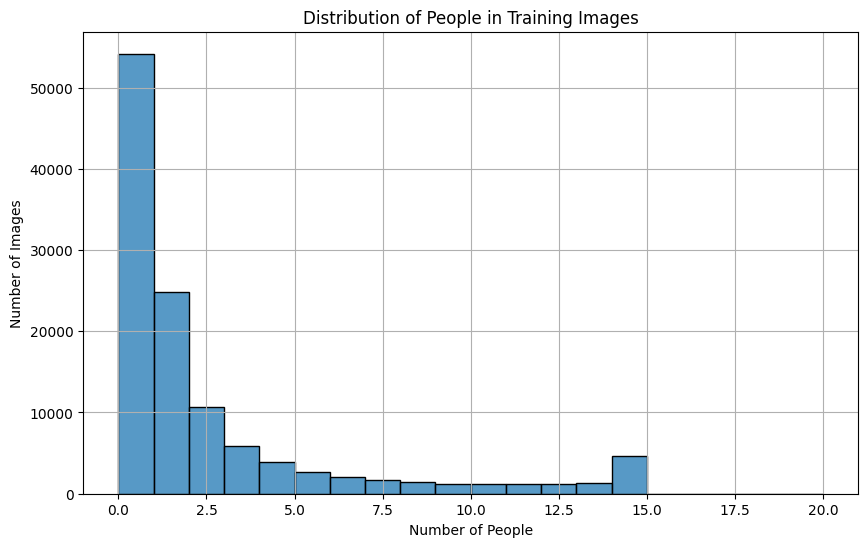

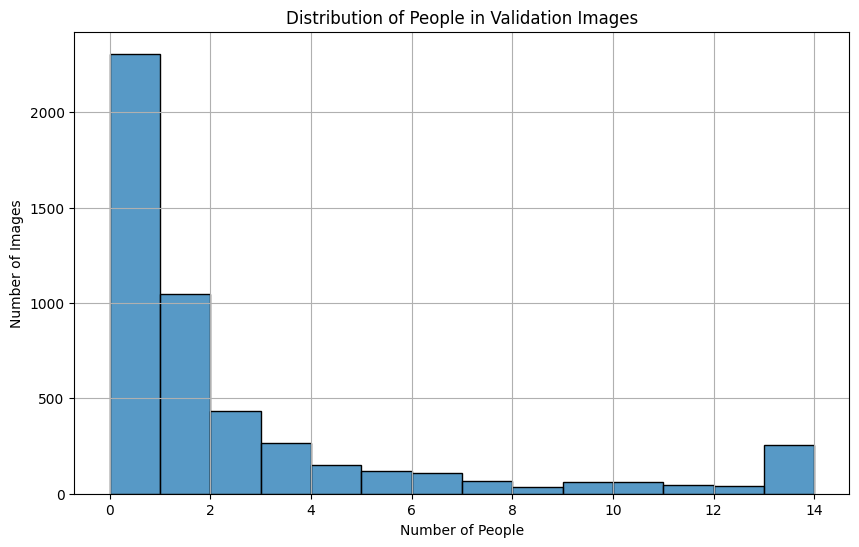

In [4]:
def plot_histogram(csv_path, title):
    # Load the CSV file
    df = pd.read_csv(csv_path)
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(df['person_count'], bins=range(0, df['person_count'].max() + 1), kde=False)
    plt.title(title)
    plt.xlabel('Number of People')
    plt.ylabel('Number of Images')
    plt.grid(True)
    plt.show()

# File paths
train_csv_path = "data/coco_dataset/train_people_count.csv"
val_csv_path = "data/coco_dataset/val_people_count.csv"

# Plot histograms
plot_histogram(train_csv_path, 'Distribution of People in Training Images')
plot_histogram(val_csv_path, 'Distribution of People in Validation Images')

# A few sample images with different person counts

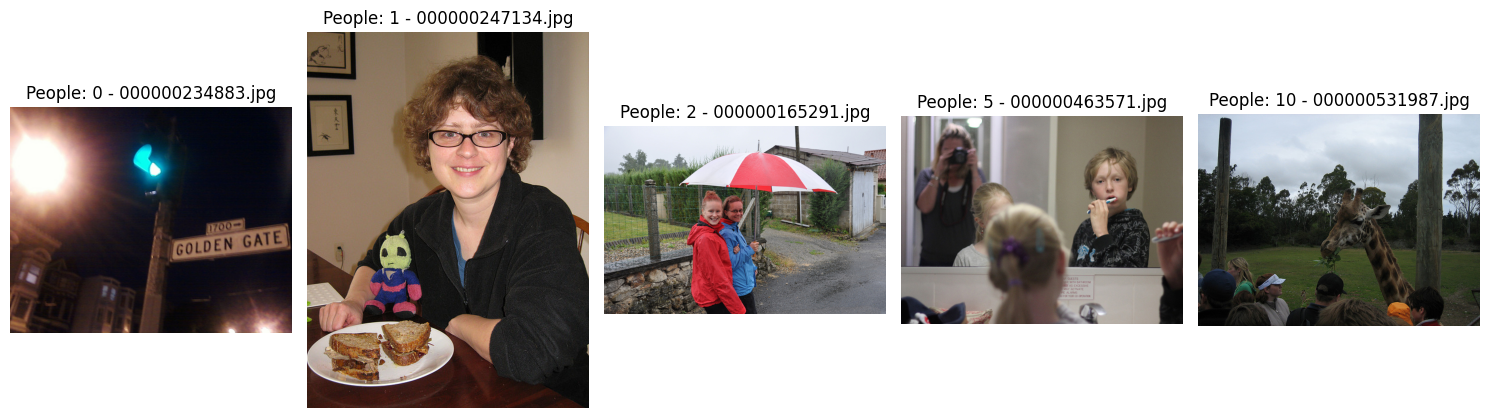

In [5]:
# Set the paths to the CSV files and images directory
train_csv_path = 'data/coco_dataset/train_people_count.csv'
image_dir = 'data/coco_dataset/train/images'

# Read the dataset
df = pd.read_csv(train_csv_path)

# People counts of interest
counts_of_interest = [0, 1, 2, 5, 10]

# Function to display an image
def display_image(ax, img_path, title):
    try:
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    except IOError:
        ax.set_title('Image not found')
        ax.axis('off')

# Create a figure with subplots
fig, axs = plt.subplots(1, len(counts_of_interest), figsize=(15, 5))

# Display an image for each people count
for ax, people_count in zip(axs, counts_of_interest):
    # Filter images with the specified count of people
    specific_count_df = df[df['person_count'] == people_count]
    
    if not specific_count_df.empty:
        # Randomly pick an image from those that have the specified count of people
        row = specific_count_df.sample(n=1).iloc[0]
        image_name = row['image_name']
        image_path = os.path.join(image_dir, image_name)
        display_image(ax, image_path, f'People: {people_count} - {image_name}')
    else:
        ax.set_title(f'No images with {people_count} people')
        ax.axis('off')

plt.tight_layout()
plt.show()

# Model Selection

The goal of the project is to identify and train a model capable of a high decree of accuracy (RMSE of <1) in counting persons in images in a range of condition.  A secondary goal is for the model to be able to run a prediction on a Raspberry Pi in a short order of time (<1 minute per image) so that prediction can be performed on an edge system.  The project will also aim to consider at least one classification based model and one regression based model.  

In considering these goals, and after extensive experimentation, I selected two categories of models for further experimentation.  The first, Yolov8, is a classification cnn (with some additional elements).  It comes pretrained on imagenet and COCO datasets, and VGG16, a regression based CNN.  Yolov8 is considered a state-of-the-art model, and is highly successful at classifying a range of objects in various situations (including all 80 classes of objects included in the COCO dataset.)  Yolov8 comes in a range of sizes, including a nano version fully capable of running predictions on a Raspberry Pi.  I decided to experiment with the nano version and the large version.

The second class of models I selected is the VGG16 regression model.  This model was used to achieve the winning entry in a Kaggle Contest that involved counting Sea Lions.  While the people I am interested ultimately in counting do not all closely resemble Sea Lions, the similarities are sufficient enough that I thought this model would be worth trying.

# Model Training and Hyperparameter Tuning for Yolov8

There were three principle hyperparameters that I considered in training the Yolov8 models.  

First, I wanted to compare the models trained to detect all object types to models specializing in detecting persons.  The default Yolov8 models come pretrained to detect all object types.  I decided to utilize transfer learning from this preexisting training but train these models further on the COCO 2017 dataset with only the person annotations selected.

The second hyperparameter was the model size to use.  I selected two model sizes for training, representing close to the full span of options with nano being the smallest and large being one off from the largest.  (There is also an extra large model that would have been impractical to train in a timely manner.)

Finally, the length of training was monitored for convergence.  The nano model reached convergence early, and training was stopped.  The large model did not reach convergence after 50 epochs (nearly 36 hours of training), and further training would have improved accuracy but time did not permit any further training.

Below, I have included the training script for the nano model.  Full training scripts and training logs are available on github.

In [6]:
a=\
"""
from ultralytics import YOLO
import os

# Define paths and parameters
def main():
    # Paths to dataset and output directory
    data_yaml = "data/person_data.yaml"  # YAML file defining the dataset
    model_path = "yolov8n.pt"  # Pre-trained YOLOv8 model
    output_dir = "runs/train"  # Directory to save training results
    epochs = 50  # Number of training epochs
    img_size = 640  # Input image size
    batch_size = 32  # Batch size

    # Train YOLOv8 model
    print(f"Starting training with model: {model_path}")
    model = YOLO(model_path)  # Load pre-trained YOLOv8 model
    model.train(
        data=data_yaml,  # Path to dataset YAML
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        project=output_dir,
        name="yolov8_people",  # Run name
        workers=4,  # Number of data loader workers
        device=0,# Use GPU 0 for training
        amp=True
    )
    print("Training complete.")

# Run the script
if __name__ == "__main__":
    main()
"""

# Results summary for the large model:


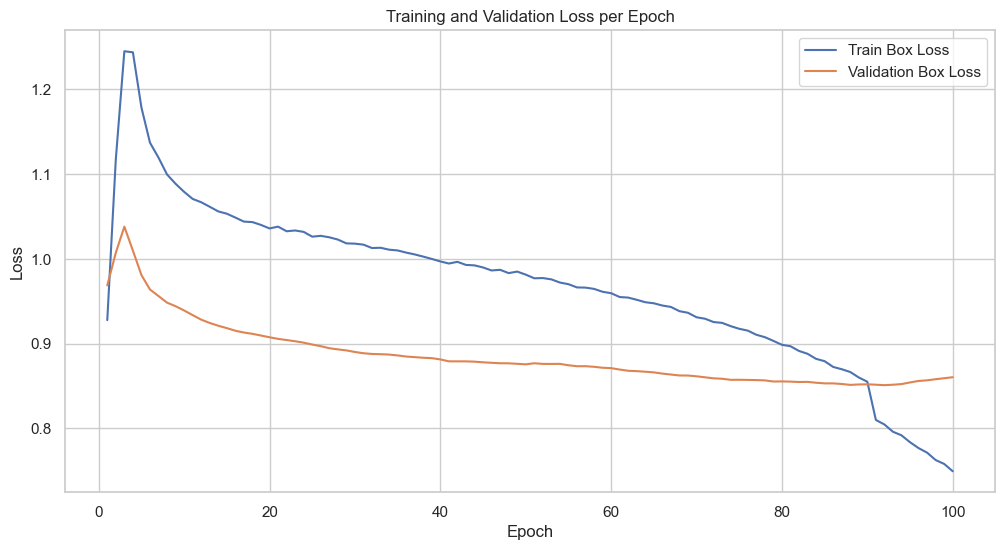

In [7]:
results_path = 'runs/train/yolov8l_people/results.csv'
df = pd.read_csv(results_path)

sns.set(style="whitegrid")

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Validation Box Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Yolov8 Regression

I also experimented extensively with adapting the Yolov8 model to perform regression by replacing the classification head with a regression head.  In theory this would allow learning transfer from the pretrained Yolov8 model to be used to create a regression model that might be more accurate for our task.  After many hours of trying, I was unsuccessful in making this work.  I identified a number of articles and discussions that suggested it could be made to work, but I was never able to successfully adapt any of them to create a working model.  I may be able to revisit this in the future as I continue to gain experience with CNN's in general and the Yolo architecture in particular.

# VGG16 Model Hyperparameter Tuning

For the VGG16 Model, I adapted the model with new layers to convert the original model's output to a single regression output representing the number of persons detected in the image.  I was able to utilize the COCO annotations to create a table with the number of persons present in each training and validation image, appropriate for regression training.

I had to carefully adjust the learning rate on the SGD function.  The initial value that I chose resulted in divergence and broken learning.  I went through several iterations before ultimately settling on an learning scheduler approach.  

I also compared training only the new layers which I created, with the original layers frozen, against then unfreezing the original layers and performing additional training.  Although the latter approach was superior, I included both models in my final results.

Below is an example of one of the VGG16 training scripts.  FUll model training scripts and logs are available on github.

In [8]:
a=\
"""
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import json
import pickle
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import datetime


log_dir = "logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir = log_dir, histogram_freq=1)

checkpoint = ModelCheckpoint(
    "checkpoint_epoch{epoch:02d}.keras",
    save_best_only=False,
    save_weights_only=False,
    verbose=1
    )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, # Stop if no improvement for 10 epochs
    restore_best_weights=True,
    verbose=1
    )

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth set.")
    except RuntimeError as e:
        print(e)

# Load the CSV file containing image names and counts
csv_path = "data/coco_dataset/train_people_count.csv"  # Replace with your CSV file path
image_folder = "data/coco_dataset/train/images"  # Replace with your image folder path
df = pd.read_csv(csv_path)

val_csv_path = "data/coco_dataset/val_people_count.csv"  # Replace with your CSV file path
val_image_folder = "data/coco_dataset/val/images"  # Replace with your image folder path
val_df = pd.read_csv(val_csv_path)

# Ensure the data contains the required columns
assert "image_name" in df.columns and "person_count" in df.columns, "CSV must contain 'image_name' and 'people_count' columns."
assert "image_name" in val_df.columns and "person_count" in val_df.columns, "CSV must contain 'image_name' and 'people_count' columns."


# Load images and their corresponding counts
def load_data(image_folder, df, img_size):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(image_folder, row["image_name"])
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=(img_size, img_size))  # Resize image
            img = img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img)
            labels.append(row["person_count"])
    return np.array(images), np.array(labels)

# Define image size
IMG_SIZE = 224  # Resize all images to 512x512
BATCH_SIZE = 32

# Define the regression model
def build_model(input_shape):

    # Load VGG16 with custom input size
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add custom layers for regression
    model = Sequential()
    model.add(vgg16)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))  # Fully connected layer
    model.add(Dense(1, activation='linear'))   # Single output for regression

    sgd = SGD(learning_rate=0.0001, momentum=0.9)

    # Compile the model
    model.compile(optimizer=sgd, loss='mse', metrics=['mae'])

    print(model.summary())

    return model

# Build and compile the model
model = build_model((IMG_SIZE, IMG_SIZE, 3))

# Create a data generator
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to [0, 1]
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255)

# Create training and validation generators
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_folder,
    x_col="image_name",
    y_col="person_count",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw",  # Raw for regression tasks
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=val_image_folder,
    x_col="image_name",
    y_col="person_count",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
)

# Fit the model

EPOCHS = 72
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks = [tensorboard_callback, lr_scheduler, checkpoint, early_stopping],
    verbose=1
)

#Evaluate the model
# Predict on the validation set
val_predictions = model.predict(val_generator)

# Extract true labels from the validation generator
true_labels = val_df["person_count"].values

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_labels, val_predictions)
print(f"Validation MAE: {mae}")

# Save the model
model.save("vgg_people_counting_model.h5")

# Save loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('vgg_training_loss_plot.png')
plt.close()

# Save MAE plot
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.savefig('vgg_training_mae_plot.png')
plt.close()

# Save training history as JSON
with open('vgg_training_history.json', 'w') as f:
    json.dump(history.history, f)

# Save training history as Pickle
with open('vgg_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('val_predictions.npy', val_predictions)
np.save('true_labels.npy', true_labels)
"""

In [9]:
results_df = pd.read_csv("updated_val_predictions.csv")
results_df.head()

,image_id,image_name,person_count,yolov8n_pred,yolov8l_pred,yolov8n_people_pred,yolov8l_people_pred,vgg16_frozen_pred,vgg16_finetuned_pred
0,397133,000000397133.jpg,2,1,2,1,2,1.904132,2.559738
1,37777,000000037777.jpg,0,0,0,0,0,-0.062730,0.086397
2,252219,000000252219.jpg,3,3,3,3,3,4.209364,4.063418
3,87038,000000087038.jpg,14,7,10,10,16,13.278651,13.928251
4,174482,000000174482.jpg,0,0,0,0,0,1.062647,1.879492


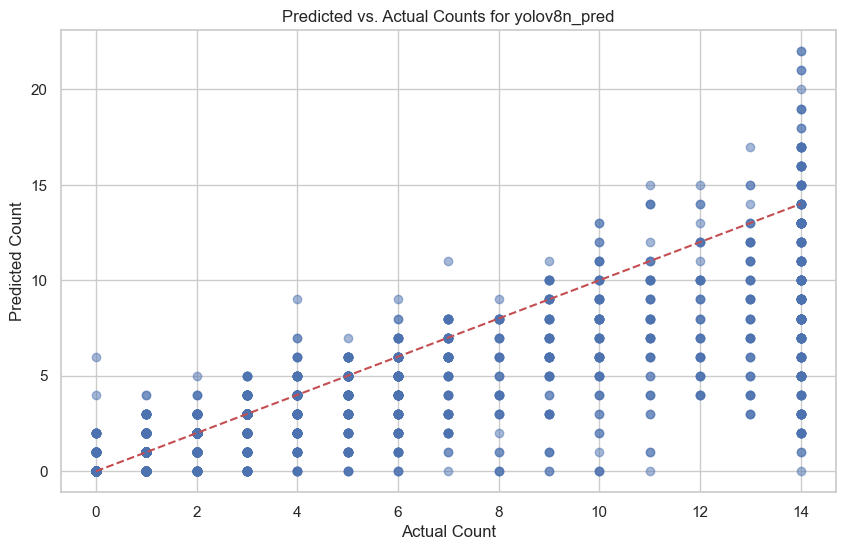

Metrics for yolov8n_pred:
MAE: 0.721, RMSE: 1.876006396577581, R²: 0.7377355440940757, MAPE: inf, Precision: 0.9758566978193146, Recall: 0.9305607129595247, F1: 0.952670594943927



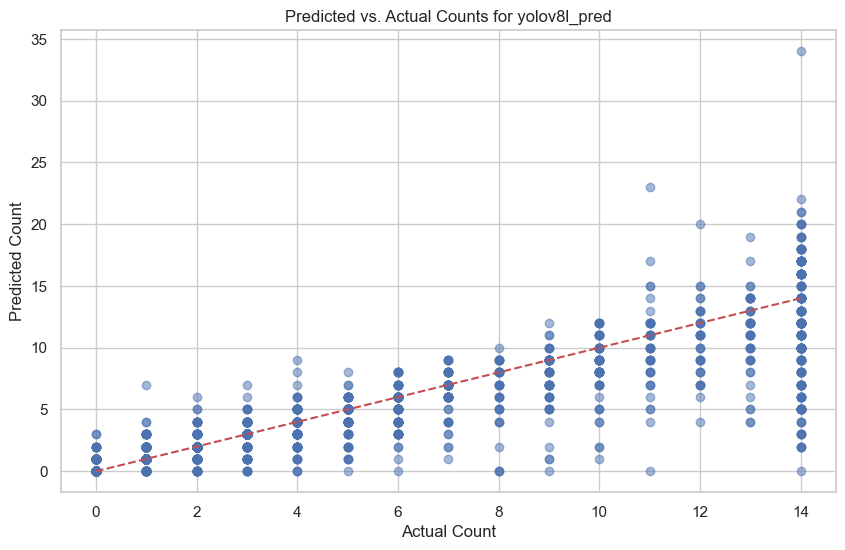

Metrics for yolov8l_pred:
MAE: 0.5082, RMSE: 1.4787156589419075, R²: 0.8370553334989219, MAPE: inf, Precision: 0.9692250648869114, Recall: 0.9706646862235425, F1: 0.9699443413729129



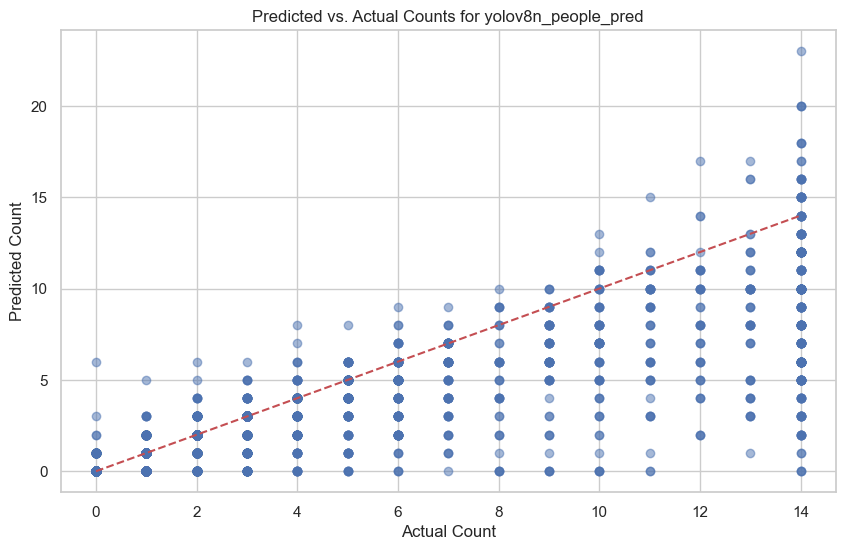

Metrics for yolov8n_people_pred:
MAE: 0.7258, RMSE: 1.9177591089602468, R²: 0.7259316315477615, MAPE: inf, Precision: 0.9773449920508744, Recall: 0.9131080579279613, F1: 0.9441351507007103



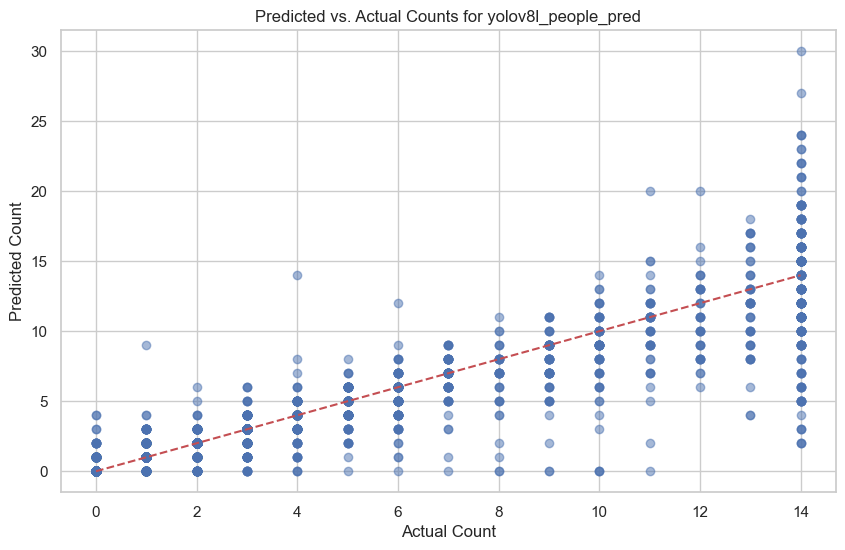

Metrics for yolov8l_people_pred:
MAE: 0.4932, RMSE: 1.4028542333400145, R²: 0.853345328970035, MAPE: inf, Precision: 0.9704893537542024, Recall: 0.9647233568510954, F1: 0.9675977653631285



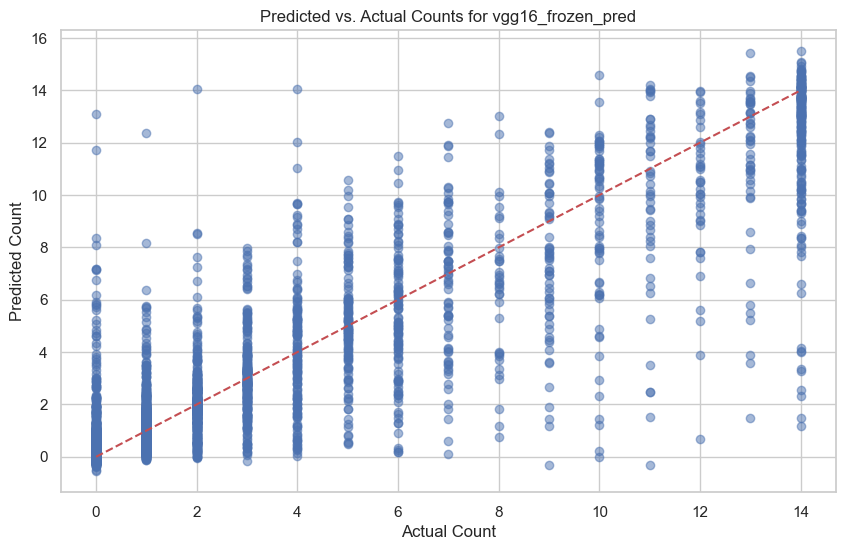

Metrics for vgg16_frozen_pred:
MAE: 0.8073748968692848, RMSE: 1.5811376833320532, R²: 0.8137011454501345, MAPE: inf, Precision: 0.6083788706739527, Recall: 0.9922020051986632, F1: 0.7542695836273818



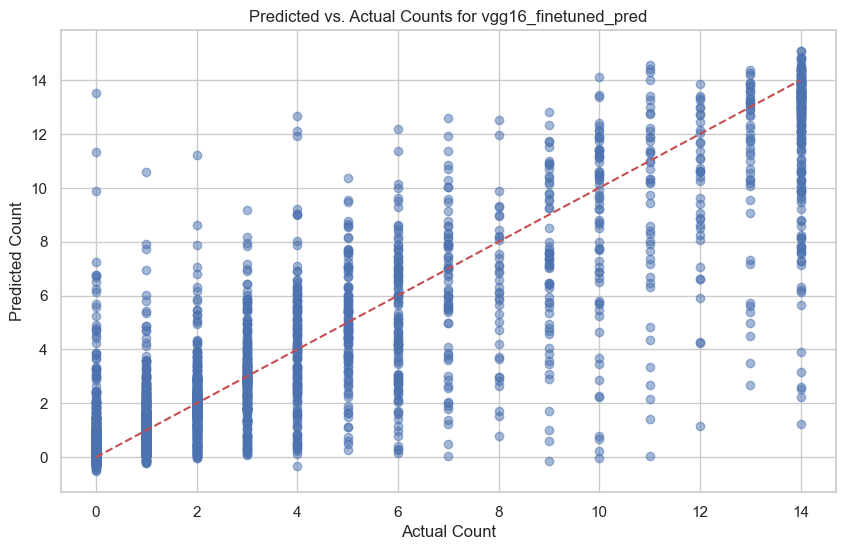

Metrics for vgg16_finetuned_pred:
MAE: 0.8027999173419653, RMSE: 1.580319226467907, R²: 0.8138939662446879, MAPE: inf, Precision: 0.6001345593182328, Recall: 0.993687337541775, F1: 0.7483221476510067



In [11]:
def calculate_metrics(data, true_col, pred_col):
    """Calculate MAE, RMSE, R², MAPE, F1, precision, recall, and confusion matrix."""
    mae = mean_absolute_error(data[true_col], data[pred_col])
    rmse = np.sqrt(mean_squared_error(data[true_col], data[pred_col]))
    r2 = r2_score(data[true_col], data[pred_col])
    mape = np.mean(np.abs((data[true_col] - data[pred_col]) / data[true_col])) * 100 if np.any(data[true_col] != 0) else float('inf')

    # Calculate F1, Precision, and Recall for binary classification
    precision = precision_score(data[true_col] > 0, data[pred_col] > 0, zero_division=0)
    recall = recall_score(data[true_col] > 0, data[pred_col] > 0)
    f1 = f1_score(data[true_col] > 0, data[pred_col] > 0, zero_division=0)

    conf_mat = confusion_matrix(data[true_col] > 0, data[pred_col] > 0)

    return mae, rmse, r2, mape, precision, recall, f1, conf_mat

def plot_predictions_vs_actuals(data, true_col, pred_col):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[true_col], data[pred_col], alpha=0.5)
    plt.plot([data[true_col].min(), data[true_col].max()], [data[true_col].min(), data[true_col].max()], 'r--')  # Ideal line
    plt.title(f'Predicted vs. Actual Counts for {pred_col}')
    plt.xlabel('Actual Count')
    plt.ylabel('Predicted Count')
    plt.grid(True)
    plt.show()

df = pd.read_csv("updated_val_predictions.csv")

# List of prediction columns, dynamically extracted
prediction_columns = [col for col in df.columns if 'pred' in col]

# Calculate metrics for each prediction model
metrics = {}
for pred_col in prediction_columns:
    mae, rmse, r2, mape, precision, recall, f1, conf_mat = calculate_metrics(df, 'person_count', pred_col)
    metrics[pred_col] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Confusion Matrix': conf_mat
    }
    # Plot confusion matrix
    plot_predictions_vs_actuals(df, 'person_count', pred_col)


    # Print metrics
    print(f"Metrics for {pred_col}:")
    print(f"MAE: {mae}, RMSE: {rmse}, R²: {r2}, MAPE: {mape}, Precision: {precision}, Recall: {recall}, F1: {f1}\n")



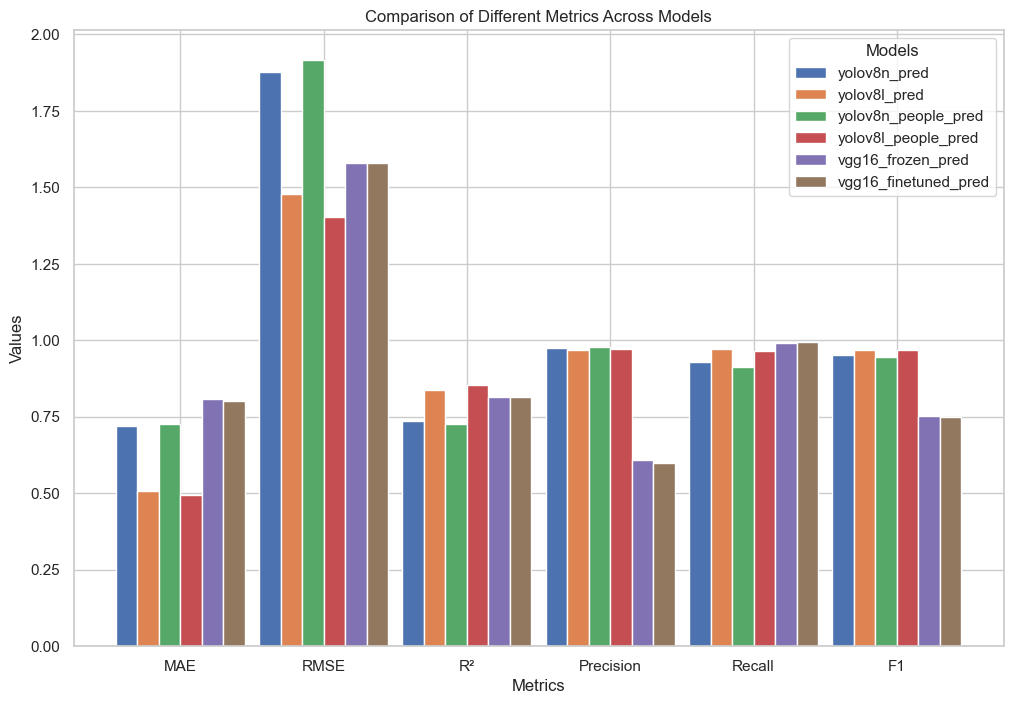

In [15]:
# Let's display a graph of the metrics:
# Define metrics for each model
models = list(metrics.keys())
measures = ['MAE', 'RMSE', 'R²', 'Precision', 'Recall', 'F1']
data = {measure: [metrics[model][measure] for model in models] for measure in measures}

fig, ax = plt.subplots(figsize=(12, 8))
width = 0.15  # the width of the bars

for i, model in enumerate(models):
    rects = ax.bar(np.arange(len(measures)) + i * width, [metrics[model][measure] for measure in measures], width, label=model)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Different Metrics Across Models')
ax.set_xticks(np.arange(len(measures)) + width * (len(models) - 1) / 2)
ax.set_xticklabels(measures)
ax.legend(title="Models")

plt.grid(True)
plt.show()

### Discussion of Results from Various Models

The results provided show a range of performance metrics for different models predicting the number of people in images. Below is a detailed discussion of these results, focusing on their implications and relative performances.

#### YOLOv8n and YOLOv8l Models
- **YOLOv8n** (`yolov8n_pred`):
  - **MAE (Mean Absolute Error) and RMSE (Root Mean Square Error):** The model has a MAE of 0.721 and RMSE of 1.876. These values indicate that, on average, the model's predictions deviate from the actual counts by less than one person, but the RMSE shows a higher average error magnitude due to the squaring of larger errors.
  - **R² (R-squared):** At 0.7377, this metric shows a moderately high level of variance explained by the model, suggesting decent prediction accuracy.
  - **Precision and Recall:** High precision (0.976) with slightly lower recall (0.931) indicates the model is conservative, making fewer false positive errors but missing some positive cases.
  - **F1 Score:** The balance between precision and recall results in a strong F1 score of 0.953, indicating effective overall performance.

- **YOLOv8l** (`yolov8l_pred`):
  - **MAE and RMSE:** Improvements in both MAE (0.508) and RMSE (1.479) over YOLOv8n suggest that YOLOv8l is more accurate and consistent.
  - **R²:** A higher R² of 0.8370 indicates that this model explains more variance in the dataset, providing better predictivity.
  - **Precision, Recall, and F1 Score:** Excellent precision and recall (both approximately 0.97), leading to a very high F1 score of 0.970. This model balances the detection of positive cases without generating many false positives.

#### YOLOv8n and YOLOv8l for People Detection
- **YOLOv8n for People Detection** (`yolov8n_people_pred`):
  - Similar performance metrics to the general prediction model, but with a slightly lower R² and slightly higher MAE and RMSE, indicating a bit less accuracy in more challenging or specific scenarios (e.g., crowded images).

- **YOLOv8l for People Detection** (`yolov8l_people_pred`):
  - Shows the best overall performance among YOLO models, with the lowest MAE and RMSE and the highest R², underscoring its robustness in varying conditions.

#### VGG16 Models
- **VGG16 Frozen** (`vgg16_frozen_pred`):
  - **MAE and RMSE:** Higher than YOLO models, indicating less accuracy in predictions.
  - **R²:** Relatively high at 0.8137, which is competitive but indicates some limitations in capturing all variance.
  - **Precision, Recall, and F1 Score:** Much lower precision compared to recall suggests a tendency to over-predict, likely due to the frozen layers not adapting well to the specifics of the people counting task.

- **VGG16 Fine-tuned** (`vgg16_finetuned_pred`):
  - Similar metrics to the frozen model, but with marginally better R², indicating slight improvements from fine-tuning.
  - Still shows a discrepancy between precision and recall, with an emphasis on maximizing recall at the cost of precision.

### Sample Image Classified Using the Fully Trained Yolov8 Large Model:

In [ ]:
image = Image.open("img/IMG_4799.jpg")

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Conclusion and Key Takeaways
- **YOLOv8l** models, especially the people-specific version, are more suited for tasks requiring high precision and recall, performing exceptionally well across all metrics.
- **VGG16 models** demonstrate the importance of fine-tuning in transfer learning settings, especially in specialized tasks like people counting, although they tend to favor recall over precision.
- **Mape results** highlight that perhaps I should have not included so many images with 0 persons in the training.  While I wanted to train on the whole Coco database, my target application does not need to be perfect at recognizing when the room is empty!  So devoting so much training time to people-less images probably was not helpful to the results.
- **Edge System Testing** I would like to continue this line of research by comparing the performance of the large Yolov8 model with the Nano model on a Raspberry Pi system for prediction.  While the Large model took much longer to train, I was pleasantly surprised at the speed of predictions once training was finished.
- **Classroom Setting** While I did not include classroom images specifically in the training or testing of this project, I did experiment with the fully trained large model on a few classroom images containing students, and found the model to correctly count the number of students present in every case.  This makes this project an overall success in paving the way for further research.
